In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

plt.rcParams['font.family'] = 'Malgun Gothic'

In [44]:
gdf = gpd.read_file("C:/Users/User/Desktop/파이썬/연습문제/venv/practical_project/csv/point_1.shp")

In [38]:
df = pd.read_csv("C:/Users/User/Desktop/파이썬/연습문제/venv/실전프로젝트/farm.csv", encoding="cp949")

In [77]:
df.drop("체세포", axis=1, inplace=True)
df.drop("수집건수", axis=1, inplace=True)
df.drop("축종코드", axis=1, inplace=True)
df.drop("제조사 아이디", axis=1, inplace=True)

In [ ]:
df.head() 

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자
0,20278,20130816010079,2021-09-01 6:52,16,2021-09-01 6:52,2021-09-01 7:04,1,7.1,N,39.9,4.1,3.3,1.5,20210902
1,20278,20130816010079,2021-09-01 17:02,17,2021-09-01 17:02,2021-09-01 17:11,2,6.8,N,40.2,4.5,3.2,2.1,20210902
2,20278,20130816010079,2021-09-02 1:41,14,2021-09-02 1:41,2021-09-02 1:51,1,6.8,N,39.9,4.8,3.1,1.9,20210903
3,20278,20130816010079,2021-09-02 7:28,10,2021-09-02 7:28,2021-09-02 7:36,2,6.8,N,39.6,5.0,3.1,1.7,20210903
4,20278,20130816010079,2021-09-02 14:33,11,2021-09-02 14:33,2021-09-02 14:45,3,6.8,N,40.0,4.7,3.2,1.3,20210903


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27926 entries, 0 to 27925
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   농장아이디   27926 non-null  int64  
 1   개체번호    27926 non-null  int64  
 2   측정일시    27926 non-null  object 
 3   착유량     27926 non-null  int64  
 4   착유시작일시  27926 non-null  object 
 5   착유종료일시  27926 non-null  object 
 6   착유회차    27926 non-null  int64  
 7   전도도     27926 non-null  float64
 8   혈액흐름    27926 non-null  object 
 9   온도      27926 non-null  float64
 10  유지방     27874 non-null  float64
 11  유단백     27874 non-null  float64
 12  공기흐름    27926 non-null  float64
 13  수집일자    27926 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 3.0+ MB


## 결측치

In [80]:
df.isnull().sum()

농장아이디      0
개체번호       0
측정일시       0
착유량        0
착유시작일시     0
착유종료일시     0
착유회차       0
전도도        0
혈액흐름       0
온도         0
유지방       52
유단백       52
공기흐름       0
수집일자       0
dtype: int64

In [81]:
df[df.isna().any(axis=1)]

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자
4210,20338,20161021020021,2021-09-08 4:58,0,2021-09-08 4:58,2021-09-08 5:01,1,7.0,N,34.6,NaN,NaN,0.2,20210909
4211,20261,20161021010036,2021-09-08 4:58,0,2021-09-08 4:58,2021-09-08 5:01,1,7.0,N,34.6,NaN,NaN,0.2,20210909
4212,20261,20161021010036,2021-09-08 16:11,1,2021-09-08 16:11,2021-09-08 16:15,2,6.6,N,38.1,NaN,NaN,1.6,20210909
4213,20338,20161021020021,2021-09-08 16:11,1,2021-09-08 16:11,2021-09-08 16:15,2,6.6,N,38.1,NaN,NaN,1.6,20210909
4216,20261,20161021010036,2021-09-10 2:30,1,2021-09-10 2:30,2021-09-10 2:35,1,6.6,N,37.0,NaN,NaN,1.8,20210911
4217,20338,20161021020021,2021-09-10 2:30,1,2021-09-10 2:30,2021-09-10 2:35,1,6.6,N,37.0,NaN,NaN,1.8,20210911
4218,20261,20161021010036,2021-09-11 1:39,1,2021-09-11 1:39,2021-09-11 1:44,1,6.6,N,36.8,NaN,NaN,1.8,20210912
4219,20338,20161021020021,2021-09-11 1:39,1,2021-09-11 1:39,2021-09-11 1:44,1,6.6,N,36.8,NaN,NaN,1.8,20210912
4238,20338,20161021020021,2021-09-21 5:00,0,2021-09-21 5:00,2021-09-21 5:06,1,4.7,N,32.4,NaN,NaN,0.3,20210922
4239,20261,20161021010036,2021-09-21 5:00,0,2021-09-21 5:00,2021-09-21 5:06,1,4.7,N,32.4,NaN,NaN,0.3,20210922


## 시점 기반 결측치 대체
 - 선형보간(linear interpolation)

In [82]:
df["유지방"].interpolate(method="linear", inplace=True)
df["유단백"].interpolate(method="linear", inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_27004\3345116318.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["유지방"].interpolate(method="linear", inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_27004\3345116318.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [83]:
df.isnull().sum()

농장아이디     0
개체번호      0
측정일시      0
착유량       0
착유시작일시    0
착유종료일시    0
착유회차      0
전도도       0
혈액흐름      0
온도        0
유지방       0
유단백       0
공기흐름      0
수집일자      0
dtype: int64

# 이상치

In [84]:
df.columns

Index(['농장아이디', '개체번호', '측정일시', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도',
       '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자'],
      dtype='object')

전도도 이상치 개수 : 1775개
온도 이상치 개수 : 680개
공기흐름 이상치 개수 : 303개
유지방 이상치 개수 : 594개
유단백 이상치 개수 : 347개
착유량 이상치 개수 : 474개


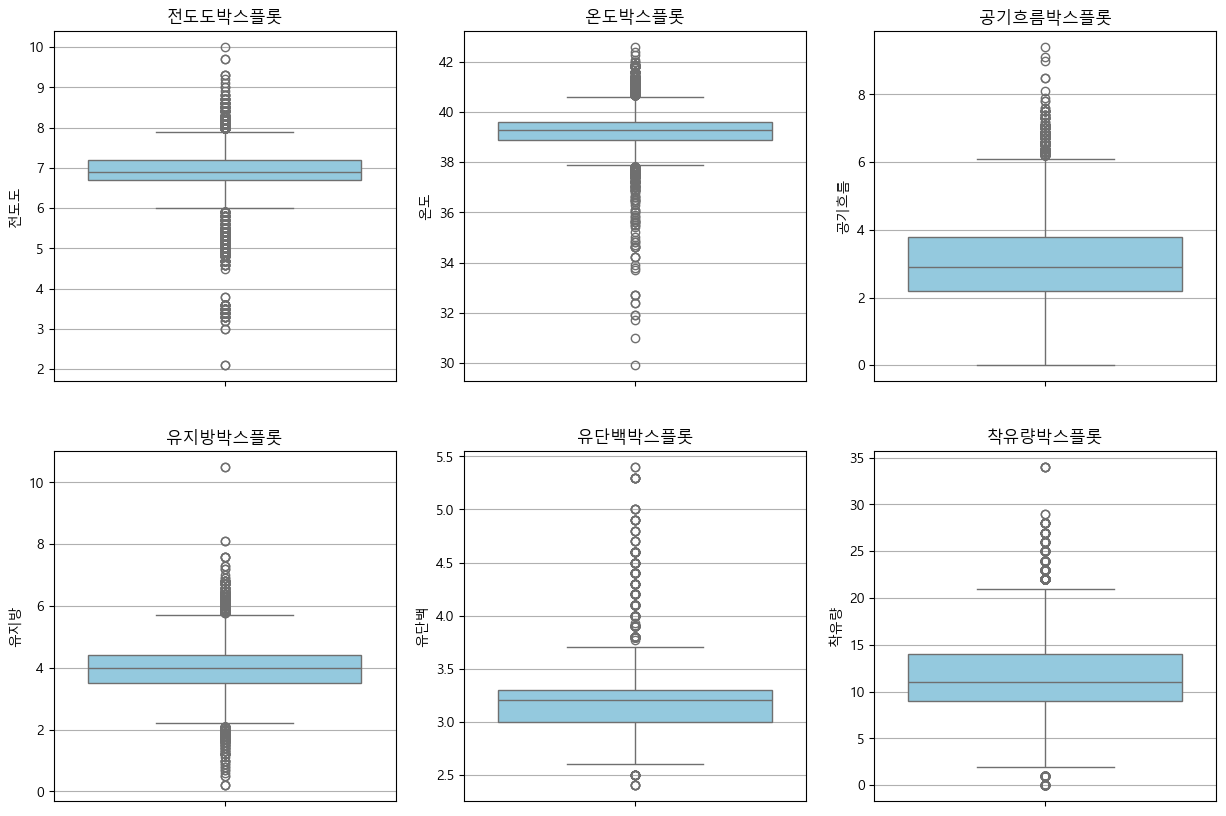

In [108]:
columns = ["전도도","온도","공기흐름","유지방","유단백","착유량"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

axes = axes.flatten()

for i, col in enumerate(columns):

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr

    ax = axes[i]

    df[f"{col}_outlier"] = (df[col]<lower_bound) | (df[col]>upper_bound)

    print(f"{col} 이상치 개수 : {df[f"{col}_outlier"].sum()}개")

    sns.boxplot(y=df[col], ax=ax, color='skyblue')

    ax.set_title(f"{col}박스플롯")
    ax.grid(axis='y',alpha=1)

plt.show()


# 분포 확인

In [86]:
df.columns

Index(['농장아이디', '개체번호', '측정일시', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도',
       '혈액흐름', '온도', '유지방', '유단백', '공기흐름', '수집일자'],
      dtype='object')

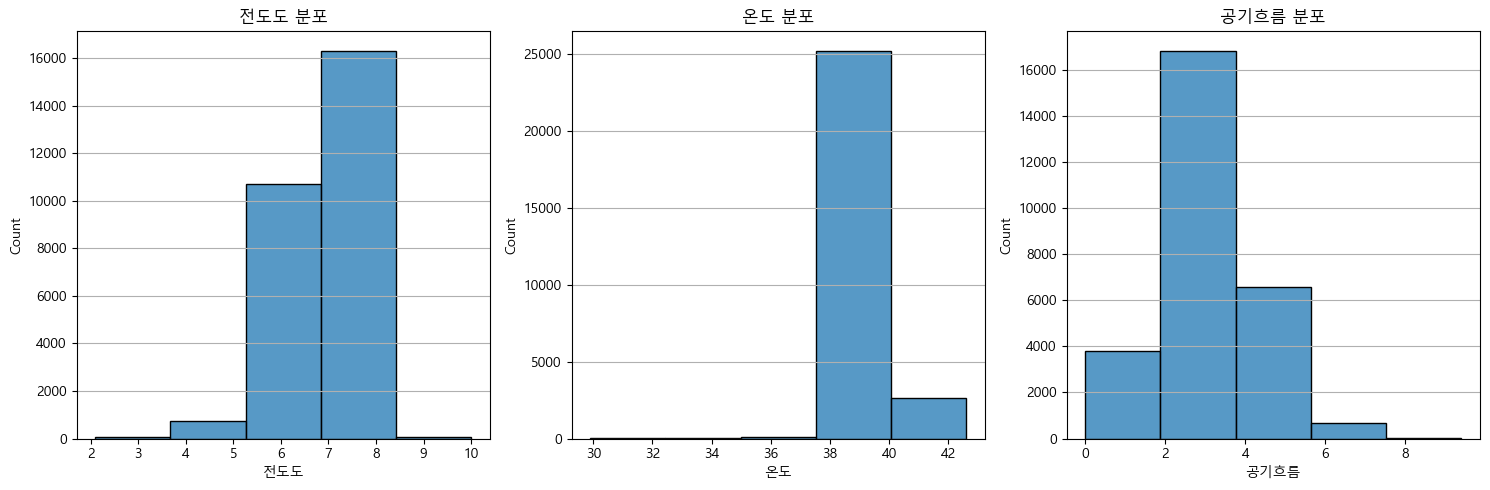

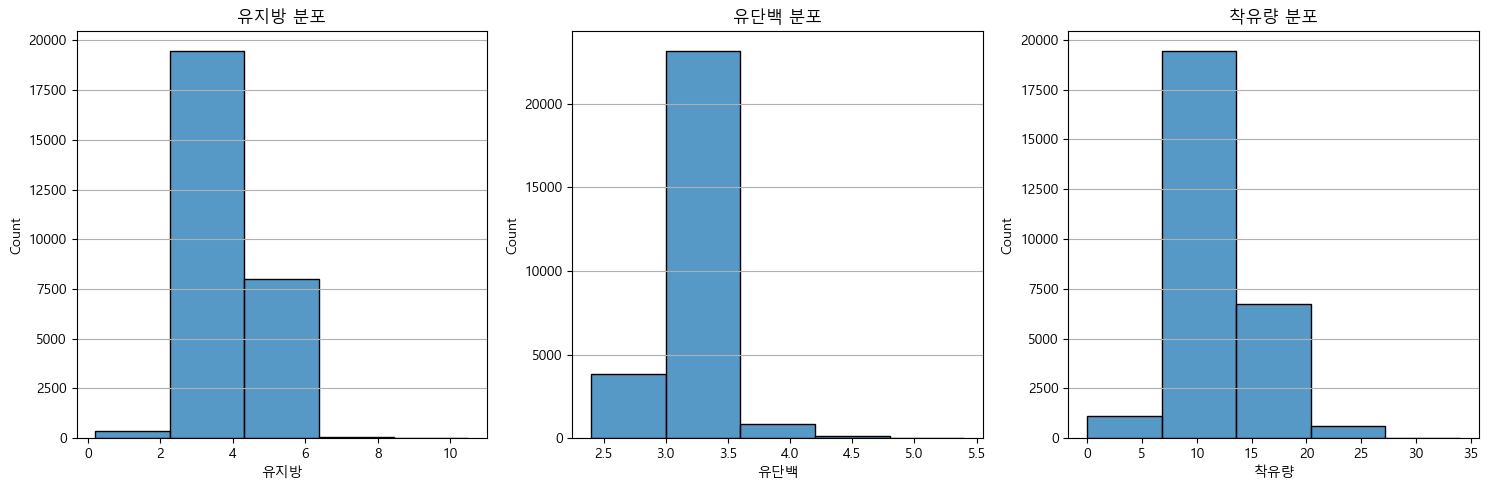

In [87]:
cols = ["착유량","전도도","온도","유지방","유단백","공기흐름"]

cols_group = [["전도도","온도","공기흐름"],["유지방","유단백","착유량"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)
        sns.histplot(data=df, x=col, bins=5)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

In [45]:
df.to_csv("test.csv", encoding="cp949")